In [1]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.utils
import torch.nn.functional as F
import torchvision.transforms as transforms

from typing import Tuple
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
!pip install umap-learn
import umap

from PIL import Image

import seaborn as sns

import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 817.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.0 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=e6c50a171e9fa80c2d4bc3d13246185ee10eb93b87742b2283fcb7679ea0cbd2
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [2]:
seed = 123
np.random.seed(seed)
_ = torch.manual_seed(seed)
_ = torch.cuda.manual_seed(seed)

In [3]:
# we select to work on GPU if it is available in the machine, otherwise will run on CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Defining the Hyper-parameters**

In [5]:
hparams = {
    'batch_size':128,
    'num_epochs':300,
    'channels':64,
    'latent_dims':70,
    'variational_beta':1,
    'learning_rate':1e-4,
    'weight_decay':1e-5,
    'dropout_prob':0.1
}

**Defining the Pytorch Dataset and the DataLoader**

In [6]:
# Define a custom transformation function
def custom_transform(piano_roll_data):
    # Convert the binary piano roll data to a NumPy array
    piano_roll_array = np.array(piano_roll_data, dtype=np.float32)

    # Convert the NumPy array to a PIL Image
    piano_roll_image = Image.fromarray(piano_roll_array)

    # Apply any additional transformations if needed
    transform = transforms.Compose([
        transforms.Resize((25, 72)),
        transforms.ToTensor(),
    ])
    piano_roll_image = transform(piano_roll_image)

    return piano_roll_image

In [7]:
class PianoRollImageDataset(Dataset):
    def __init__(self, data_folder, file_list, transform=None):
        self.data_folder = data_folder
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.data_folder, file_name)

        piano_roll_data = []
        # Read the piano roll data from the text file
        with open(file_path, "r") as file:
            for i, line in enumerate(file):
                piano_roll_data.append([int(val) for val in line.split()])

        # Check the dimensions
        vertical_dimension = len(piano_roll_data)
        horizontal_dimension = len(piano_roll_data[0])

        # Convert to a PyTorch tensor using the custom transformation
        piano_roll_image = custom_transform(piano_roll_data)

        return piano_roll_image, file_name

In [8]:
# Define the data folder
data_folder = '/content/drive/MyDrive/TFM/68_4_bar_dataset'

# Split the dataset into training, validation, and test sets
file_list = os.listdir(data_folder) # 1913 files
train_files, val_files = train_test_split(file_list, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(val_files, test_size=0.333, random_state=42)

# Dataset initialization
train_dataset = PianoRollImageDataset(data_folder, transform=custom_transform, file_list=train_files)
val_dataset = PianoRollImageDataset(data_folder, transform=custom_transform, file_list=val_files)
test_dataset = PianoRollImageDataset(data_folder, transform=custom_transform, file_list=test_files)

# Dataloaders initialization
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=hparams['batch_size'],
    shuffle=True,
    drop_last=True,
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=hparams['batch_size'],
    shuffle=False,
    drop_last=True,
)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=192,
    shuffle=False,
    drop_last=True,
)

In [9]:
print(len(train_dataset)) # 70%
print(len(val_dataset)) # 20%
print(len(test_dataset)) # 10%

1339
382
192


In [10]:
# Define the participant ID you want to extract
participant_id = "A01"

# Get all files related to the participant_id from the data_folder
participant_files = [file_name for file_name in file_list if participant_id in file_name]

# Dataset initialization for the specific participant
participant_dataset = PianoRollImageDataset(data_folder, transform=custom_transform, file_list=participant_files)

# Dataloader initialization for the specific participant
participant_dataloader = DataLoader(
    dataset=participant_dataset,
    batch_size=30,
    shuffle=False,
    drop_last=True,
)

In [56]:
whole_dataset = PianoRollImageDataset(data_folder, transform=custom_transform, file_list=file_list)

# Dataloader initialization for the specific participant
whole_dataloader = DataLoader(
    dataset=whole_dataset,
    batch_size=len(whole_dataset),
    shuffle=False,
    drop_last=True,
)




**VAE Definition**

In [11]:
class Encoder(nn.Module):
    def __init__(
            self,
            channels: int,
            latent_dims: int,
            ) -> None:

        super(Encoder, self).__init__()

        self.c = channels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.c, kernel_size=(25,6), stride=1, padding=3)
        self.dropout1 = nn.Dropout2d(p=hparams['dropout_prob'])
        self.conv2 = nn.Conv2d(in_channels=self.c, out_channels=self.c*2, kernel_size=7, stride=2, padding=3)
        self.dropout2 = nn.Dropout2d(p=hparams['dropout_prob'])
        self.fc_mu = nn.Linear(in_features=self.c*2*4*37, out_features=hparams['latent_dims'])
        self.fc_logvar = nn.Linear(in_features=self.c*2*4*37, out_features=hparams['latent_dims'])

    def forward(self, x: torch.Tensor)-> Tuple[torch.Tensor, torch.Tensor]:
        #print(x.shape) # [128, 1, 25, 72]
        out = F.relu(self.conv1(x))
        #print(out.shape) # [128, 64, 7, 73]
        out = self.dropout1(out)
        out = F.relu(self.conv2(out))
        #print(out.shape) # [128, 128, 4, 37]
        out = self.dropout2(out)
        out = out.view(out.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        #print(out.shape) # [128, 18944]

        x_mu = self.fc_mu(out)
        #print(x_mu.shape) # [128, 512]
        x_logvar = self.fc_logvar(out)
        #print(x_logvar.shape) # [128, 512]

        return x_mu, x_logvar

In [12]:
class Decoder(nn.Module):
    def __init__(
            self,
            channels: int,
            latent_dims: int
            ) -> None:

        super(Decoder, self).__init__()
        self.c = channels
        self.fc = nn.Linear(in_features=hparams['latent_dims'], out_features=self.c*2*4*37)
        self.conv2 = nn.ConvTranspose2d(in_channels=self.c*2, out_channels=self.c, kernel_size=7, stride=2, padding=3)
        self.dropout1 = nn.Dropout2d(p=hparams['dropout_prob'])
        self.conv1 = nn.ConvTranspose2d(in_channels=self.c, out_channels=1, kernel_size=(25,6), stride=1, padding=3)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        #print(z.shape) # [128, 512]

        out = self.fc(z)
        #print(out.shape) # [128, 18944]
        out = out.view(out.size(0), self.c*2, 4, 37) # unflatten batch
        #print(out.shape) # [128, 128, 4, 37]
        out = F.relu(self.conv2(out))
        #print(out.shape) # [128, 64, 7, 73]
        out = self.dropout1(out)
        out = torch.sigmoid(self.conv1(out, output_size=(out.size(0), 1, 25, 72))) # without output_size, out would be [128, 1, 24, 72]
        #print(out.shape) # [128, 1, 25, 72]

        return out

In [13]:
class VariationalAutoencoder(nn.Module):
    def __init__(
            self,
            z_dims: int,
            n_ch: int,
            ) -> None:

        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(channels=n_ch,latent_dims=z_dims)
        self.decoder = Decoder(channels=n_ch, latent_dims=z_dims)

    def reparametrize(
            self,
            mu:torch.Tensor,
            logvar:torch.Tensor,
            ) -> torch.Tensor:
        # Given mean and logvar returns z
        # reparameterization trick: instead of sampling from Q(z|X), sample epsilon = N(0,I)
        # mu, logvar: mean and log of variance of Q(z|X)

        # The factor 1/2 in the exponent ensures that the distribution has unit variance
        std = torch.exp(0.5 * logvar)
        # Random sample
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x: torch.Tensor) -> Tuple[
            torch.Tensor, torch.Tensor, torch.Tensor]:
        latent_mu, latent_logvar = self.encoder(x)
        z = self.reparametrize(latent_mu, latent_logvar)
        x_recon = self.decoder(z)

        return x_recon, latent_mu, latent_logvar

**Define Loss Function**

In [14]:
def vae_loss(
        recon_x: torch.Tensor,
        x: torch.Tensor,
        mu: torch.Tensor,
        logvar: torch.Tensor,
        variational_beta: int=1,
        ) -> float:
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.

    input_size = x.size(2) * x.size(3)

    recon_loss = F.binary_cross_entropy(recon_x.view(-1, input_size), x.view(-1, input_size), reduction='sum')
    kldivergence = variational_beta * (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()))
    elbo_loss = (recon_loss +  kldivergence)/x.shape[0]

    return elbo_loss, recon_loss, kldivergence

**Training**

In [ ]:
def train_batch(
        image_batch: torch.Tensor,
        vae: torch.nn.Module,
        vae_loss: torch.nn.Module,
        optimizer: torch.optim,
        ) -> float:

    image_batch = image_batch.to(device) # [128, 1, 25, 72]

    image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
    elbo_loss, recon_loss, kldivergence = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

    # backpropagation
    optimizer.zero_grad()
    elbo_loss.backward()

    # one step of the optmizer (using the gradients from backpropagation)
    optimizer.step()

    return elbo_loss.item(), recon_loss.item(), kldivergence.item()

In [ ]:
# Load checkpoint
checkpoint=torch.load('/content/drive/MyDrive/TFM/my_vae_2.pth', map_location=torch.device('cpu'))

vae = VariationalAutoencoder(z_dims = hparams['latent_dims'], n_ch = hparams['channels'])
vae.load_state_dict(checkpoint)
print('model loaded')

vae.to(device)

model loaded


VariationalAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(25, 6), stride=(1, 1), padding=(3, 3))
    (dropout1): Dropout2d(p=0.1, inplace=False)
    (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (dropout2): Dropout2d(p=0.1, inplace=False)
    (fc_mu): Linear(in_features=18944, out_features=70, bias=True)
    (fc_logvar): Linear(in_features=18944, out_features=70, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=70, out_features=18944, bias=True)
    (conv2): ConvTranspose2d(128, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (dropout1): Dropout2d(p=0.1, inplace=False)
    (conv1): ConvTranspose2d(64, 1, kernel_size=(25, 6), stride=(1, 1), padding=(3, 3))
  )
)

In [ ]:
# Freeze convolutional layers in the encoder
for name, param in vae.encoder.named_parameters():
    if 'conv' in name:  # Assuming your convolutional layers have 'conv' in their names
        param.requires_grad = False

# Freeze convolutional layers in the decoder
for name, param in vae.decoder.named_parameters():
    if 'conv' in name:  # Assuming your convolutional layers have 'conv' in their names
        param.requires_grad = False

In [ ]:
start_time=time.time()

optimizer = torch.optim.Adam(params=vae.parameters(), lr=hparams['learning_rate'], weight_decay=hparams['weight_decay'])

# This is the number of parameters used in the model
num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params}')

# set to training mode
vae.train()

train_loss_avg = {"elbo": [], "likelihood": [], "kl_div": []}
val_loss_avg = {"elbo": [], "likelihood": [], "kl_div": []}

print('Training ...')
for epoch in range(hparams['num_epochs']):
    train_loss_avg["elbo"].append(0)
    train_loss_avg["likelihood"].append(0)
    train_loss_avg["kl_div"].append(0)
    num_batches = 0

    for i,(image_batch,_) in enumerate(train_dataloader):

        elbo_loss, likelihood, kl_div = train_batch(image_batch, vae, vae_loss, optimizer)
        train_loss_avg["elbo"][-1] += elbo_loss
        train_loss_avg["likelihood"][-1] += likelihood
        train_loss_avg["kl_div"][-1] += kl_div

    train_loss_avg["elbo"][-1] /= i
    train_loss_avg["likelihood"][-1] /= i
    train_loss_avg["kl_div"][-1] /= i

    print(
        f"Epoch [{epoch + 1} / {hparams['num_epochs']}] Training ELBO loss: {train_loss_avg['elbo'][-1]:.4f}, "
        f"Likelihood loss: {train_loss_avg['likelihood'][-1]:.4f}, "
        f"KL divergence loss: {train_loss_avg['kl_div'][-1]:.4f}"
    )

    # Set to validation mode
    vae.eval()
    with torch.no_grad():
        val_loss_avg["elbo"].append(0)
        val_loss_avg["likelihood"].append(0)
        val_loss_avg["kl_div"].append(0)

        for i, (x_val_batch, _) in enumerate(val_dataloader):
            x_val_batch = x_val_batch.to(device)
            x_val_batch_recon, latent_mu, latent_logvar = vae(x_val_batch)
            val_elbo_loss, val_likelihood, val_kl_div = vae_loss(x_val_batch_recon, x_val_batch, latent_mu, latent_logvar)
            val_loss_avg["elbo"][-1] += val_elbo_loss.item()
            val_loss_avg["likelihood"][-1] += val_likelihood.item()
            val_loss_avg["kl_div"][-1] += val_kl_div.item()

        val_loss_avg["elbo"][-1] /= i
        val_loss_avg["likelihood"][-1] /= i
        val_loss_avg["kl_div"][-1] /= i

        print(
            f"Epoch [{epoch + 1} / {hparams['num_epochs']}] Validation ELBO loss: {val_loss_avg['elbo'][-1]:.4f}, "
            f"Likelihood loss: {val_loss_avg['likelihood'][-1]:.4f}, "
            f"KL divergence loss: {val_loss_avg['kl_div'][-1]:.4f}"
        )
    vae.train()

print("--- TOTAL TIME: %s min ---" % (round((time.time() - start_time) / 60, 3)))

Number of parameters: 3997324
Training ...
Epoch [1 / 300] Training ELBO loss: 281.9471, Likelihood loss: 28997.3207, KL divergence loss: 7091.9072
Epoch [1 / 300] Validation ELBO loss: 426.9576, Likelihood loss: 41666.0527, KL divergence loss: 12984.5156
Epoch [2 / 300] Training ELBO loss: 239.7007, Likelihood loss: 23164.4373, KL divergence loss: 7517.2566
Epoch [2 / 300] Validation ELBO loss: 372.9740, Likelihood loss: 33944.0020, KL divergence loss: 13796.6714
Epoch [3 / 300] Training ELBO loss: 212.8675, Likelihood loss: 19265.4422, KL divergence loss: 7981.5987
Epoch [3 / 300] Validation ELBO loss: 337.0161, Likelihood loss: 28581.5234, KL divergence loss: 14556.5386
Epoch [4 / 300] Training ELBO loss: 191.6631, Likelihood loss: 16183.3817, KL divergence loss: 8349.4994
Epoch [4 / 300] Validation ELBO loss: 302.7197, Likelihood loss: 23612.3389, KL divergence loss: 15135.7798
Epoch [5 / 300] Training ELBO loss: 176.7737, Likelihood loss: 14065.7197, KL divergence loss: 8561.3126


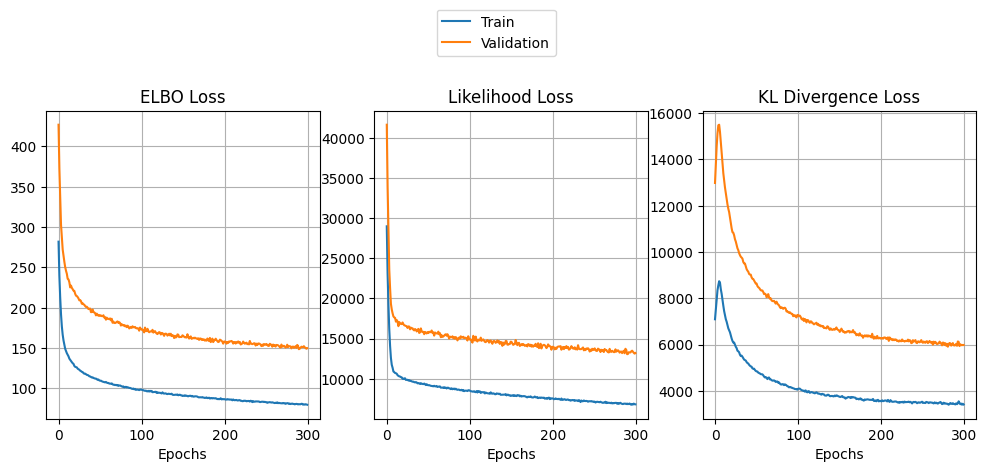

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# fig.tight_layout()

loss_types = ["elbo", "likelihood", "kl_div"]
y_labels = ["ELBO Loss", "Likelihood Loss", "KL Divergence Loss"]

for i, loss_type in enumerate(loss_types):
    (train_h,) = axs[i].plot(train_loss_avg[loss_type], label="Train")
    (val_h,) = axs[i].plot(val_loss_avg[loss_type], label="Validation")
    axs[i].set_xlabel("Epochs")
    axs[i].set_title(y_labels[i])
    axs[i].grid(True)

fig.legend(handles=[train_h, val_h], loc="upper center", bbox_to_anchor=(0.5, 1.15))
plt.show()

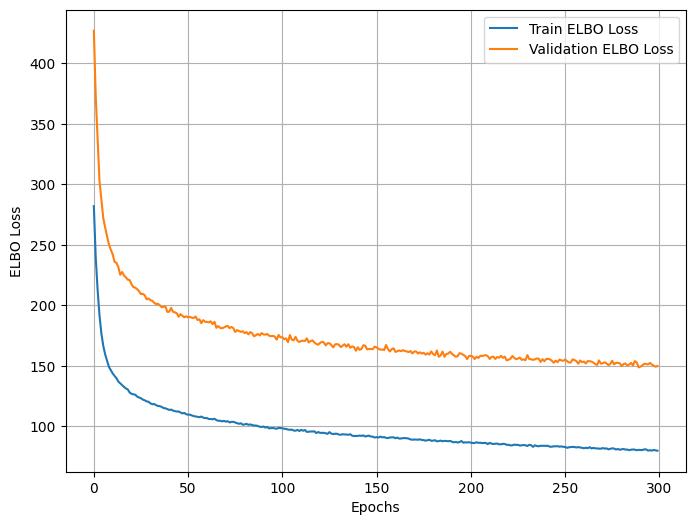

In [ ]:
plt.figure(figsize=(8, 6))

train_elbo, = plt.plot(train_loss_avg['elbo'], label="Train ELBO Loss")
val_elbo, = plt.plot(val_loss_avg['elbo'], label="Validation ELBO Loss")

plt.xlabel("Epochs")
plt.ylabel("ELBO Loss")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# this is how the VAE parameters can be saved:
torch.save(vae.state_dict(), '/content/drive/MyDrive/TFM/my_vae_ft_2.pth')

In [16]:
# Load checkpoint
checkpoint=torch.load('/content/drive/MyDrive/TFM/my_vae_ft_2.pth', map_location=torch.device('cpu'))

vae = VariationalAutoencoder(z_dims = hparams['latent_dims'], n_ch = hparams['channels'])
vae.load_state_dict(checkpoint)
print('model loaded')

model loaded


### Evaluate on the Test Set

In [58]:
# Set to evaluation mode
vae.eval()

latent_mu_list = []
latent_logvar_list = []
class_labels_64_list = []
class_labels_2_list = []

all_participants_count = {}

with torch.no_grad():
    test_loss_avg = {"elbo": 0, "likelihood": 0, "kl_div": 0}
    num_test_batches = 0

    for x_test_batch, file_names in test_dataloader:
        x_test_batch = x_test_batch
        # VAE reconstruction
        x_test_batch_recon, latent_mu_test, latent_logvar_test = vae(
            x_test_batch
        )

        # Calculate reconstruction error and other losses
        test_loss, likelihood, kl_div = vae_loss(
            x_test_batch_recon,
            x_test_batch,
            latent_mu_test,
            latent_logvar_test,
        )

        test_loss_avg["elbo"] += test_loss.item()
        test_loss_avg["likelihood"] += likelihood.item()
        test_loss_avg["kl_div"] += kl_div.item()
        num_test_batches += 1

        latent_mu_list.append(latent_mu_test.cpu().numpy())
        latent_logvar_list.append(latent_logvar_test.cpu().numpy())

        class_labels_64_list.extend([file_name.split('_')[1] for file_name in file_names])
        class_labels_2_list.extend([file_name.split('_')[1][0] for file_name in file_names])

        # Update participant counts in the test set
        for file_name in file_names:
            participant_code = file_name.split('_')[1]
            if participant_code not in all_participants_count:
                all_participants_count[participant_code] = 1
            else:
                all_participants_count[participant_code] += 1

    # Calculate average losses
    test_loss_avg["elbo"] /= num_test_batches
    test_loss_avg["likelihood"] /= num_test_batches
    test_loss_avg["kl_div"] /= num_test_batches

# Print and save the test losses
print("Average ELBO loss on test data: %f" % test_loss_avg["elbo"])
print("Average Likelihood loss on test data: %f" % test_loss_avg["likelihood"])
print("Average KL Divergence loss on test data: %f" % test_loss_avg["kl_div"])

# Combine all latent_mu and latent_logvar into single matrices
latent_mu_test = np.concatenate(latent_mu_list, axis=0)
latent_logvar_test = np.concatenate(latent_logvar_list, axis=0)

# Combine mu and logvar into one matrix & extract class labels
latent_matrix = np.concatenate((latent_mu_test, latent_logvar_test), axis=1)
class_labels_64 = np.array(class_labels_64_list)
class_labels_2 = np.array(class_labels_2_list)

Average ELBO loss on test data: 80.268829
Average Likelihood loss on test data: 10848.572266
Average KL Divergence loss on test data: 4563.043457


In [19]:
# # Set to evaluation mode
# vae.eval()

# latent_mu_list = []
# latent_logvar_list = []
# class_labels_30_list = []

# all_participants_count = {}

# with torch.no_grad():
#     for x_test_batch, file_names in participant_dataloader:

#         # VAE reconstruction
#         x_test_batch_recon, latent_mu_test, latent_logvar_test = vae(
#             x_test_batch
#         )

#         # Calculate reconstruction error and other losses
#         test_loss, likelihood, kl_div = vae_loss(
#             x_test_batch_recon,
#             x_test_batch,
#             latent_mu_test,
#             latent_logvar_test,
#         )

#         latent_mu_list.append(latent_mu_test.cpu().numpy())
#         latent_logvar_list.append(latent_logvar_test.cpu().numpy())

#         class_labels_30_list.extend([file_name.split('_')[5] for file_name in file_names])

#         # Update participant counts in the test set
#         for file_name in file_names:
#             participant_code = file_name.split('_')[1]
#             if participant_code not in all_participants_count:
#                 all_participants_count[participant_code] = 1
#             else:
#                 all_participants_count[participant_code] += 1

# # Combine all latent_mu and latent_logvar into single matrices
# latent_mu_test = np.concatenate(latent_mu_list, axis=0)
# latent_logvar_test = np.concatenate(latent_logvar_list, axis=0)

# # Combine mu and logvar into one matrix & extract class labels
# latent_matrix = np.concatenate((latent_mu_test, latent_logvar_test), axis=1)
# class_labels_30 = np.array(class_labels_30_list)

In [59]:
# 'all_participants_count' dictionary now contains counts of each participant in the test set
print("Participants and their counts in the test set:")
for participant, count in all_participants_count.items():
    print(f"Participant {participant}: {count} occurrences")

Participants and their counts in the test set:
Participant A09: 3 occurrences
Participant A31: 3 occurrences
Participant A13: 5 occurrences
Participant A05: 5 occurrences
Participant P26: 2 occurrences
Participant P18: 2 occurrences
Participant P07: 3 occurrences
Participant A02: 5 occurrences
Participant A23: 4 occurrences
Participant P24: 4 occurrences
Participant A08: 2 occurrences
Participant P08: 4 occurrences
Participant A27: 3 occurrences
Participant P14: 4 occurrences
Participant P31: 4 occurrences
Participant P28: 4 occurrences
Participant A01: 6 occurrences
Participant P21: 3 occurrences
Participant P11: 4 occurrences
Participant P01: 3 occurrences
Participant P20: 2 occurrences
Participant P06: 2 occurrences
Participant P30: 2 occurrences
Participant P32: 3 occurrences
Participant P19: 3 occurrences
Participant A06: 3 occurrences
Participant P03: 3 occurrences
Participant A29: 3 occurrences
Participant A15: 2 occurrences
Participant A22: 4 occurrences
Participant P02: 4 occu

**Visualize Generated Images**

In [21]:
# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x: torch.Tensor) -> torch.Tensor:
    x = x.clamp(0, 1)
    return x

def show_image(img: torch.Tensor) -> None:
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')

def one_hot_encode(image: torch.Tensor) -> torch.Tensor:
    max_indices = torch.argmax(image, dim=1, keepdim=True)
    binary_image = torch.zeros_like(image)
    binary_image.scatter_(1, max_indices, 1)
    return image
    #return binary_image

@torch.no_grad()
def visualise_output(images: torch.Tensor, model: nn.Module, device: torch.device) -> None:
    images = images.to(device)
    model.to(device)
    recon_images, _, _ = model(images)
    recon_images = recon_images.cpu()

    # Plot each original-reconstructed pair separately
    for i in range(images.size(0)):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        show_image(one_hot_encode(images[i].cpu()))

        plt.subplot(1, 2, 2)
        plt.title('Reconstructed Image')
        show_image(one_hot_encode(recon_images[i]))

        plt.show()

VAE reconstruction:


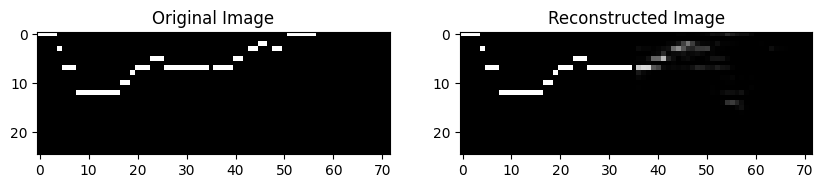

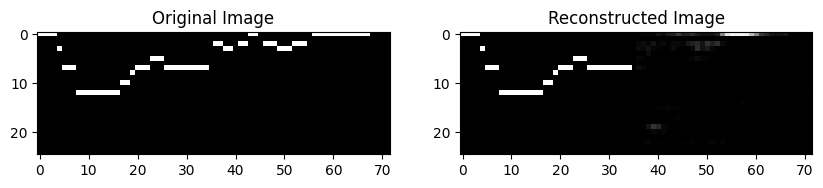

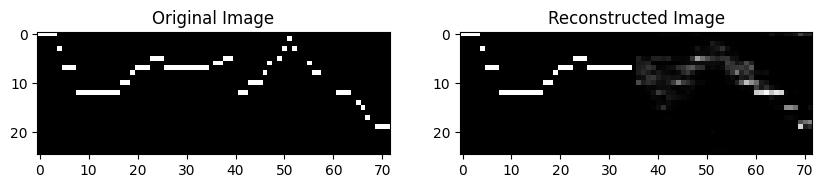

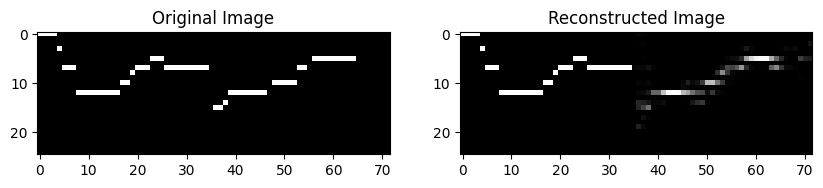

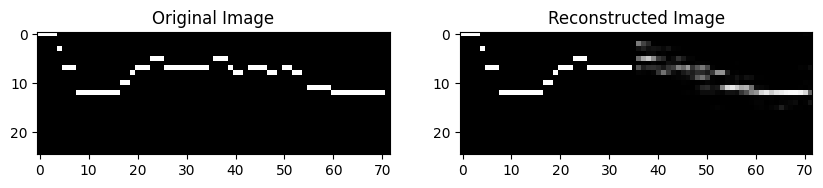

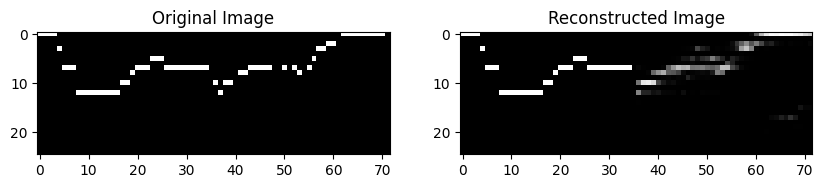

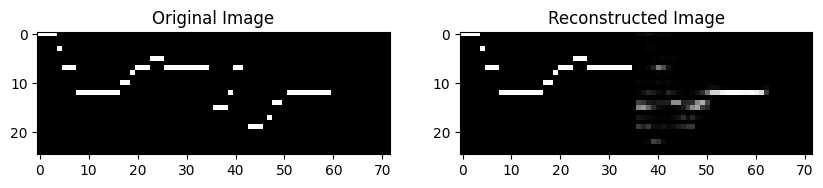

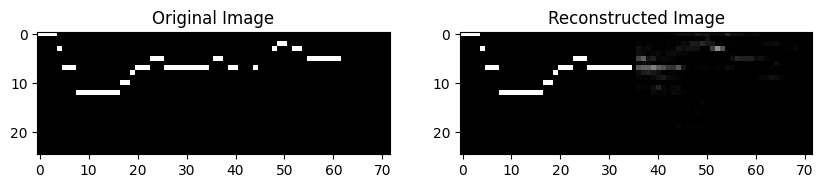

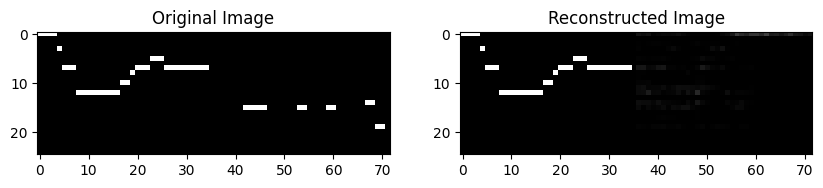

In [22]:
vae.eval()
test_data_iterator = iter(test_dataloader)
images, labels = next(test_data_iterator)

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images[1:10], vae, device)

**Analyze Latent Space**

Shape of Latent Matrix: (192, 140)


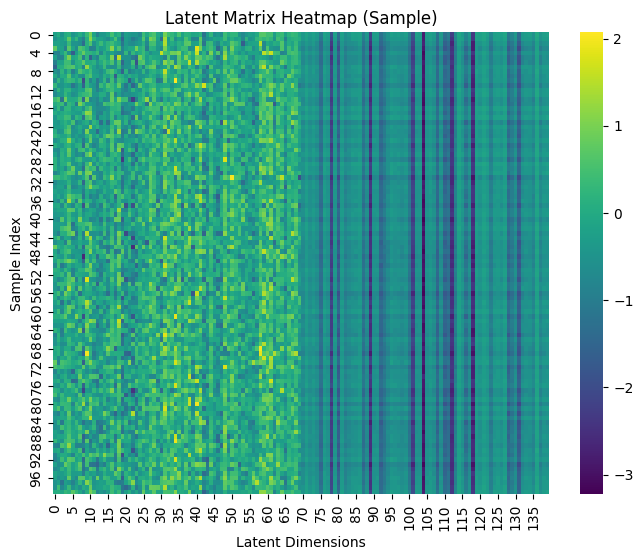

In [61]:
# Assuming latent_matrix is the concatenated matrix

print("Shape of Latent Matrix:", latent_matrix.shape)
# 192 samples in test set (rows)
# 70*2 latent dimension = features (columns)

# Visualizing a heatmap of the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(latent_matrix[:100], cmap='viridis')  # Displaying the first 100 rows as a heatmap
plt.title('Latent Matrix Heatmap (Sample)')
plt.xlabel('Latent Dimensions')
plt.ylabel('Sample Index')
plt.show()


In [24]:
# Perform Singular Value Decomposition (SVD)
U, s, V = np.linalg.svd(latent_matrix, full_matrices=False)

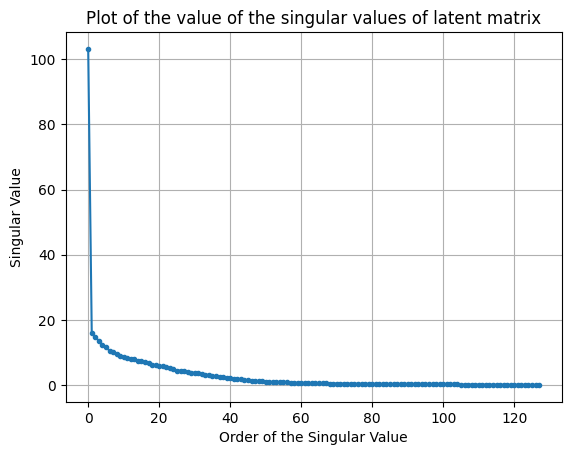

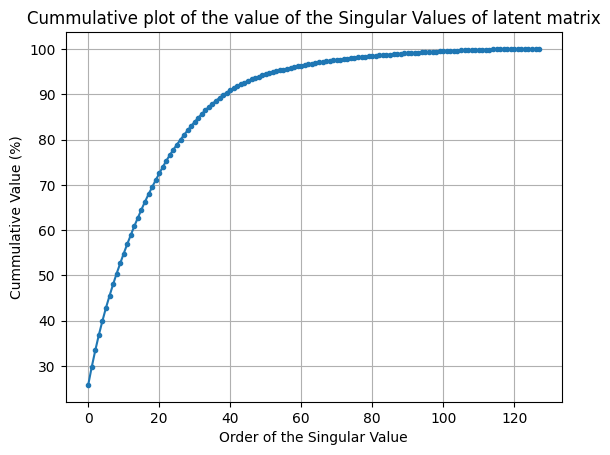

In [25]:
SignValue = s
plt.plot(SignValue,'.-');
plt.title(f'Plot of the value of the singular values of latent matrix')
plt.ylabel('Singular Value')
plt.xlabel('Order of the Singular Value')
plt.grid(True)
plt.show()

plt.plot(np.cumsum(SignValue)/np.sum(SignValue)*100,'.-');
plt.title(f'Cummulative plot of the value of the Singular Values of latent matrix')
plt.ylabel('Cummulative Value (%)')
plt.xlabel('Order of the Singular Value')
plt.grid(True)
plt.show()

In [20]:
num_components = hparams['latent_dims']

In [49]:
# Filter the latent matrix and class labels for class 'A'
class_A_indices = np.where(class_labels_2 == 'A')[0]
latent_matrix_class_A = latent_matrix[class_A_indices]
class_labels_64_class_A = class_labels_64[class_A_indices]

# Filter the latent matrix and class labels for class 'P'
class_P_indices = np.where(class_labels_2 == 'P')[0]
latent_matrix_class_P = latent_matrix[class_P_indices]
class_labels_64_class_P = class_labels_64[class_P_indices]

In [62]:
# Perform Principal Component Analysis (PCA)

#pca = PCA(n_components='mle')
pca = PCA(n_components=num_components)
#pca = PCA(n_components=30)
#pca = PCA(n_components=len(class_A_indices))
pca_result = pca.fit_transform(latent_matrix_class_A)
print(pca.n_components_)

70


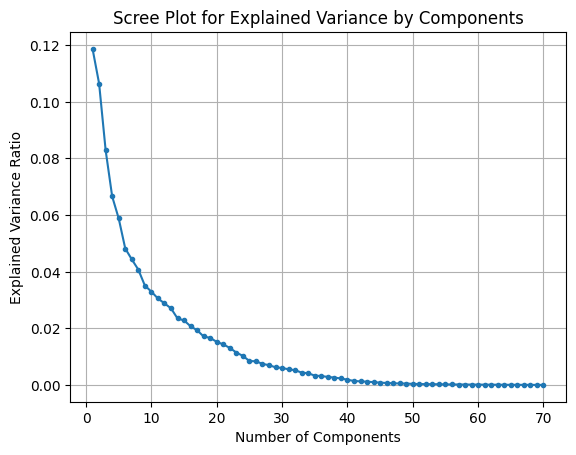

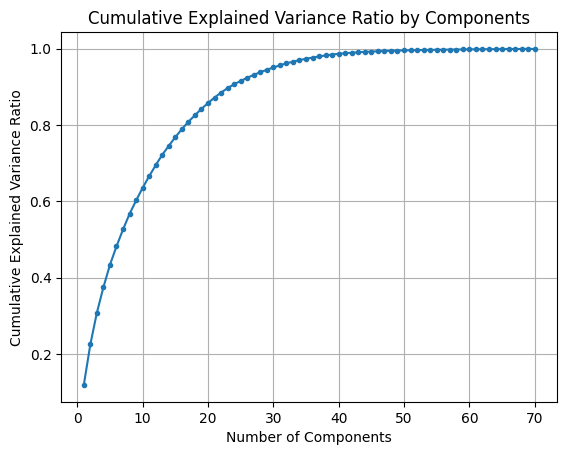

In [29]:
# Obtain the explained variance ratios and cumulative explained variance
explained_variance_ratios = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratios)

# Plotting the scree plot
#plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratios) + 1), explained_variance_ratios, '.-')
plt.title('Scree Plot for Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Plotting cumulative explained variance
#plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, '.-')
plt.title('Cumulative Explained Variance Ratio by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [53]:
# Convert class labels to numeric values
label_df = pd.DataFrame(class_labels_64_class_P, columns=['Class'])
label_df['ClassID'] = label_df['Class'].astype('category').cat.codes  # Convert labels to numeric IDs

# Get unique classes from the data
unique_classes = label_df['Class'].unique()

# Create a colormap for the classes
colormap = plt.cm.get_cmap('plasma', len(unique_classes))

<ipython-input-53-e45fd7ce9f2a>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('plasma', len(unique_classes))


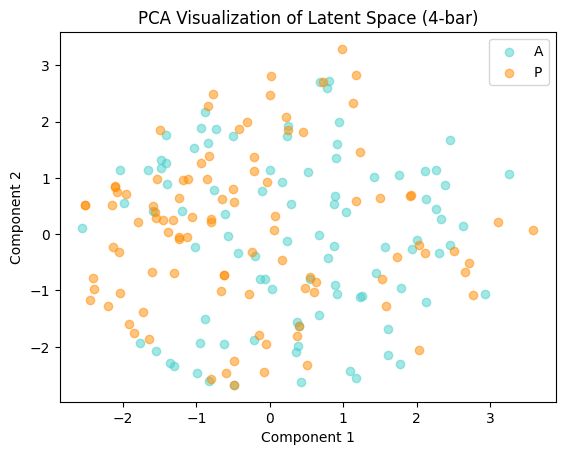

In [48]:
colors = {'A': 'mediumturquoise', 'P': 'darkorange'}

for class_label, color in colors.items():
    class_indices = label_df[label_df['Class'] == class_label].index
    plt.scatter(
        pca_result[class_indices, 0],
        pca_result[class_indices, 1],
        label=class_label,
        color=color,
        alpha=0.5
    )

plt.title('PCA Visualization of Latent Space (4-bar)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

In [24]:
# Combine the components in a DataFrame for visualization
n_comps = 10
pca_df = pd.DataFrame(data=pca_result[:, :n_comps], columns=[f'Component {i+1}' for i in range(n_comps)])

# Add class labels to the DataFrame
pca_df['Class'] = label_df['Class']

# Create a scatter matrix
scatter_matrix = sns.pairplot(pca_df, hue='Class', palette='plasma')

# Access the current figure and axes to plot the legend separately
fig = plt.gcf()
handles = list(scatter_matrix._legend_data.values())[:1]
labels = list(scatter_matrix._legend_data.keys())[:1]
fig.legend(handles, labels, loc='center right')

plt.suptitle('Pairwise Scatter Matrix of Principal Components', fontsize=20, position=(0.5, 1))
plt.show()


Output hidden; open in https://colab.research.google.com to view.

<ipython-input-33-ef144bcdc5b0>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


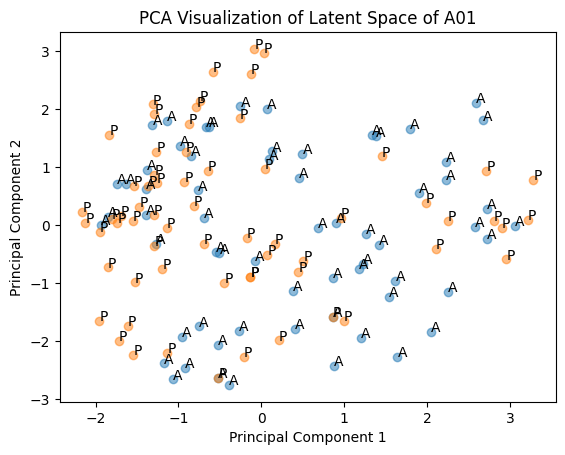

In [33]:
# Create a scatter plot with annotations for trial numbers
for i, class_label in enumerate(unique_classes):
    class_indices = label_df[label_df['Class'] == class_label].index
    plt.scatter(
        pca_result[class_indices, 0],
        pca_result[class_indices, 1],
        label=f'Trial {class_label}',  # Label each point with its trial number
        cmap=colormap,
        alpha=0.5
    )
    # Annotate each point with its trial number
    for idx in class_indices:
        plt.annotate(str(class_label), (pca_result[idx, 0], pca_result[idx, 1]))

plt.title('PCA Visualization of Latent Space of A01')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


<ipython-input-34-cb8d7c21b013>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


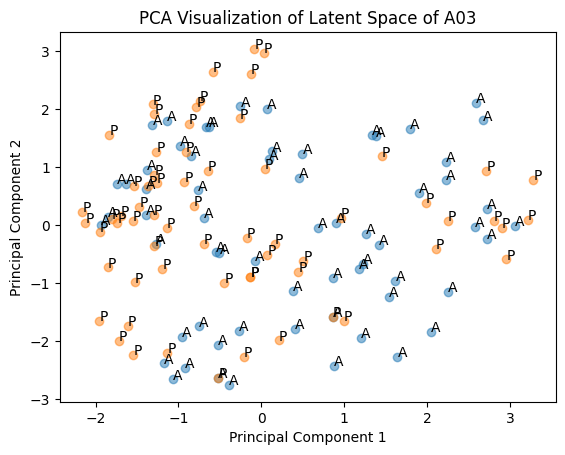

In [34]:
# Create a scatter plot with annotations for trial numbers
for i, class_label in enumerate(unique_classes):
    class_indices = label_df[label_df['Class'] == class_label].index
    plt.scatter(
        pca_result[class_indices, 0],
        pca_result[class_indices, 1],
        label=f'Trial {class_label}',  # Label each point with its trial number
        cmap=colormap,
        alpha=0.5
    )
    # Annotate each point with its trial number
    for idx in class_indices:
        plt.annotate(str(class_label), (pca_result[idx, 0], pca_result[idx, 1]))

plt.title('PCA Visualization of Latent Space of A03')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


<ipython-input-35-7fbfcb197f14>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


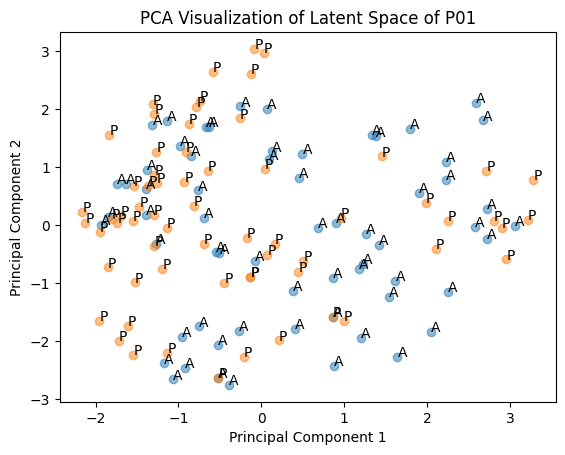

In [35]:
# Create a scatter plot with annotations for trial numbers
for i, class_label in enumerate(unique_classes):
    class_indices = label_df[label_df['Class'] == class_label].index
    plt.scatter(
        pca_result[class_indices, 0],
        pca_result[class_indices, 1],
        label=f'Trial {class_label}',  # Label each point with its trial number
        cmap=colormap,
        alpha=0.5
    )
    # Annotate each point with its trial number
    for idx in class_indices:
        plt.annotate(str(class_label), (pca_result[idx, 0], pca_result[idx, 1]))

plt.title('PCA Visualization of Latent Space of P01')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


<ipython-input-36-86a462bf0bb0>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


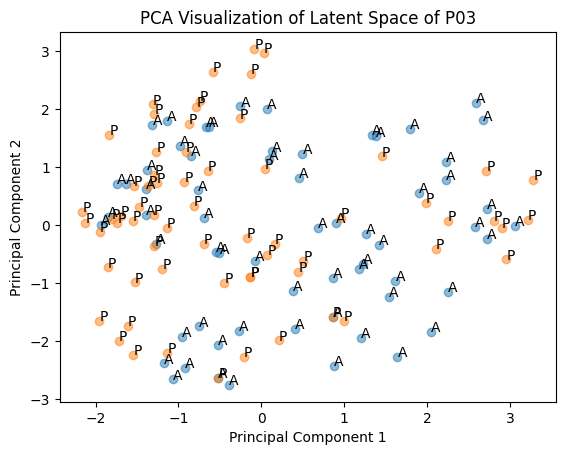

In [36]:
# Create a scatter plot with annotations for trial numbers
for i, class_label in enumerate(unique_classes):
    class_indices = label_df[label_df['Class'] == class_label].index
    plt.scatter(
        pca_result[class_indices, 0],
        pca_result[class_indices, 1],
        label=f'Trial {class_label}',  # Label each point with its trial number
        cmap=colormap,
        alpha=0.5
    )
    # Annotate each point with its trial number
    for idx in class_indices:
        plt.annotate(str(class_label), (pca_result[idx, 0], pca_result[idx, 1]))

plt.title('PCA Visualization of Latent Space of P03')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


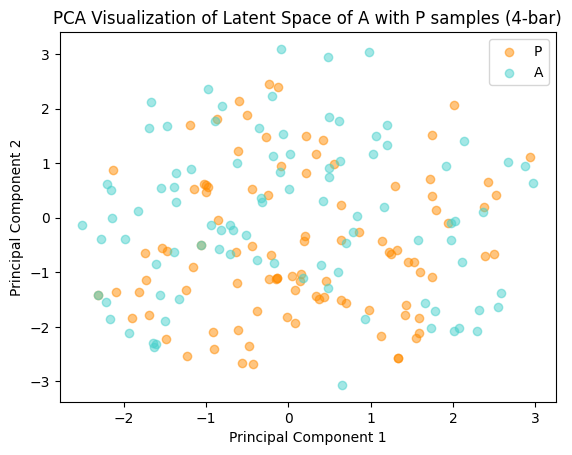

In [65]:
pca_result_P = pca.transform(latent_matrix_class_P)

# Scatter plot for class 'P'
plt.scatter(
    pca_result_P[:, 0],
    pca_result_P[:, 1],
    label='P',
    color='darkorange',
    alpha=0.5
)

# Scatter plot for class 'A'
plt.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    label='A',
    color='mediumturquoise',
    alpha=0.5
)

plt.title('PCA Visualization of Latent Space of A with P samples (4-bar)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


**Visualize Latent Space**

In [25]:
# t-SNE
tsne = TSNE(n_components=3, random_state=42)
latent_tsne = tsne.fit_transform(latent_matrix)
print(latent_tsne.shape)

(192, 3)


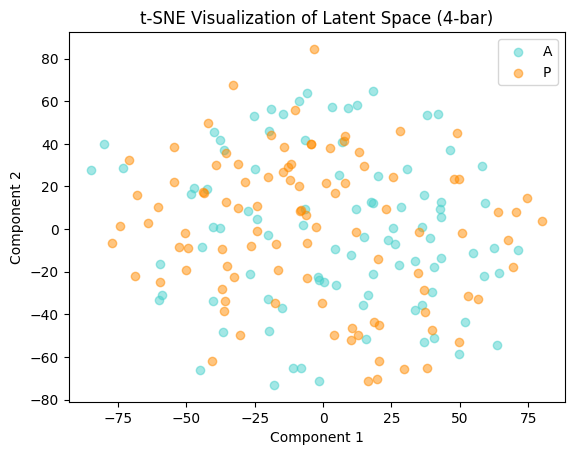

In [47]:
colors = {'A': 'mediumturquoise', 'P': 'darkorange'}

for class_label, color in colors.items():
    class_indices = label_df[label_df['Class'] == class_label].index
    plt.scatter(
        latent_tsne[class_indices, 0],
        latent_tsne[class_indices, 1],
        label=class_label,
        color=color,
        alpha=0.5
    )

plt.title('t-SNE Visualization of Latent Space (4-bar)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

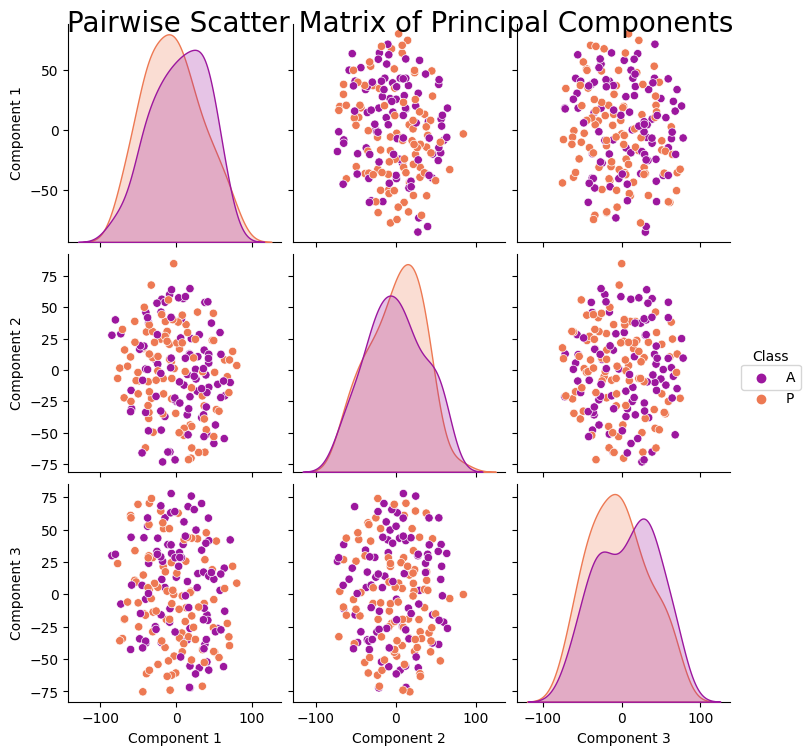

In [27]:
# Combine the components in a DataFrame for visualization
tsne_df = pd.DataFrame(data=latent_tsne[:, :3], columns=[f'Component {i+1}' for i in range(3)])

# Add class labels to the DataFrame
tsne_df['Class'] = label_df['Class']

# Create a scatter matrix
scatter_matrix = sns.pairplot(tsne_df, hue='Class', palette='plasma')

# Access the current figure and axes to plot the legend separately
fig = plt.gcf()
handles = list(scatter_matrix._legend_data.values())[:1]
labels = list(scatter_matrix._legend_data.keys())[:1]
fig.legend(handles, labels, loc='center right')

plt.suptitle('Pairwise Scatter Matrix of Principal Components', fontsize=20, position=(0.5, 1))
plt.show()

In [28]:
# MDS
mds = MDS(n_components=num_components, random_state=42)
latent_mds = mds.fit_transform(latent_matrix)
print(latent_mds.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


(192, 70)


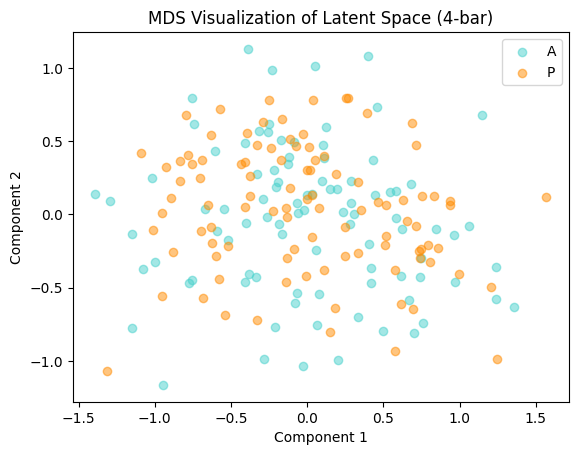

In [46]:
colors = {'A': 'mediumturquoise', 'P': 'darkorange'}

for class_label, color in colors.items():
    class_indices = label_df[label_df['Class'] == class_label].index
    plt.scatter(
        latent_mds[class_indices, 0],
        latent_mds[class_indices, 1],
        label=class_label,
        color=color,
        alpha=0.5
    )

plt.title('MDS Visualization of Latent Space (4-bar)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

In [30]:
# Combine the components in a DataFrame for visualization
mds_df = pd.DataFrame(data=latent_mds[:, :10], columns=[f'Component {i+1}' for i in range(10)])

# Add class labels to the DataFrame
mds_df['Class'] = label_df['Class']

# Create a scatter matrix
scatter_matrix = sns.pairplot(mds_df, hue='Class', palette='plasma')

# Access the current figure and axes to plot the legend separately
fig = plt.gcf()
handles = list(scatter_matrix._legend_data.values())[:1]
labels = list(scatter_matrix._legend_data.keys())[:1]
fig.legend(handles, labels, loc='center right')

plt.suptitle('Pairwise Scatter Matrix of Principal Components', fontsize=20, position=(0.5, 1))
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [31]:
# UMAP
umap_emb = umap.UMAP(n_components=num_components, random_state=42)
latent_umap = umap_emb.fit_transform(latent_matrix)
print(latent_umap.shape)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(192, 70)


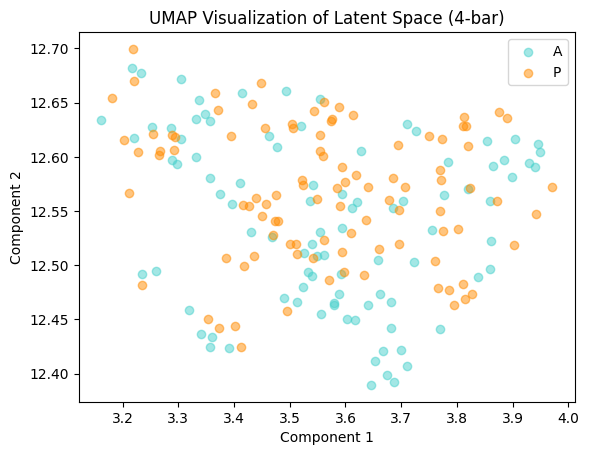

In [45]:
colors = {'A': 'mediumturquoise', 'P': 'darkorange'}

for class_label, color in colors.items():
    class_indices = label_df[label_df['Class'] == class_label].index
    plt.scatter(
        latent_umap[class_indices, 0],
        latent_umap[class_indices, 1],
        label=class_label,
        color=color,
        alpha=0.5
    )

plt.title('UMAP Visualization of Latent Space (4-bar)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

In [33]:
# Combine the components in a DataFrame for visualization
umap_df = pd.DataFrame(data=latent_umap[:, :10], columns=[f'Component {i+1}' for i in range(10)])

# Add class labels to the DataFrame
umap_df['Class'] = label_df['Class']

# Create a scatter matrix
scatter_matrix = sns.pairplot(umap_df, hue='Class', palette='plasma')

# Access the current figure and axes to plot the legend separately
fig = plt.gcf()
handles = list(scatter_matrix._legend_data.values())[:1]
labels = list(scatter_matrix._legend_data.keys())[:1]
fig.legend(handles, labels, loc='center right')

plt.suptitle('Pairwise Scatter Matrix of Principal Components', fontsize=20, position=(0.5, 1))
plt.show()


Output hidden; open in https://colab.research.google.com to view.